# Preparations

In [1]:
%config InlineBackend.figure_format ='retina'
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [30]:
import os
import copy
import numpy as np
import msprime
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from IPython.core.display import SVG

In [3]:
import utils

# Lab session: recombination rate estimation using Recurrent Neural Networks

## Aims

In this lab session we will build a Recurrent Neural Network model for estimating recombination rates from sequence variation data. The model is based on the article Predicting the Landscape of Recombination Using Deep Learning <cite data-cite="482049/A2QE4JIT"></cite>. ReLERNN estimates recombination rate landscapes directly from genotype alignments expressed as vcf files. We will partly reproduce the network model of ReLERNN.

According to the developers, ReLERNN is accurate even when faced with demographic misspecifications, missing genotypes, and genome inaccessibility. They also claim it performs well at small sample sizes and can also take as input allele frequencies estimated from Pool-seq data.

Recombination rates vary along chromosomes, between chromosomes, between species and more. Importantly, they affect the test stastitics of genome-wide scans for e.g. selection <cite data-cite="482049/M6IAUADD"></cite>: 

<div><img src="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4617962/bin/1656f01.jpg" width=800></img>



For this reason, <cite data-cite="482049/CSCF6VJF"></cite> stress the importance of including recombination rate data when performing population genomic analyses.


FIXME: add paragraph on what data input looks like; text-based full sequence alignment -> segregating sites + positions

The method that we will look at uses coalescent simulations to generate data. The data needs to be preprocessed prior to training, and a substantial part of this lab will therefore be devoted to data preparation. Once data is in an appopriate format, we turn to modelling. Briefly then, the aims of this lab are:

1. to familiarize yourself with the coalescent simulator msprime
2. to proprocess the data
3. to familiarize yourself with the code for producing data inputs in sequence batches
4. to train and apply the model to some toy examples

If time permits, there are some additional suggestions at the end, including testing the software package ReLERNN itself.

## Mini-introduction to msprime

As we will use msprime (https://msprime.readthedocs.io/en/stable/index.html) to simulate both observed data, as well as training and test data, we here provide a mini-introduction to the few commands that are required.

The basic idea of the coalescent process is to relate a set of individuals, or sequences, to oneother through a genealogy, looking *backwards* in time. The genealogy is built iteratively by sampling two sequences to have a common ancestor and to merge those lineages at a time in the past. The distance to that past event is given as a Poisson variable with intensity proportional to the number of individuals currently alive. The process is repeated until only one individual remains.

Once the genealogy has been generated, mutations are added following a Poisson process by sprinkling them on the genealogy. The probability that a mutation ends up on a particular branch is proportional to the branch length. The independence of the genealogy and mutation process is a consequence of the assumption that mutations are selectively *neutral*. Thus, the independence does not hold for loci being selected upon.

To begin with, we show the simplest command for simulating a small sample (n=6) of 1kb sequences from a population with a diploid effective population size 1000 ($N_e$=1000) and printing a genealogy:

In [4]:
import msprime
tree_sequence = msprime.simulate(sample_size=6, Ne=1000, length=1e4, random_seed=46)
tree = tree_sequence.first()
print(tree.draw(format="unicode"))

      10   
    ┏━━┻━━┓
    9     ┃
 ┏━━┻━┓   ┃
 ┃    8   ┃
 ┃   ┏┻━┓ ┃
 7   ┃  ┃ ┃
┏┻┓  ┃  ┃ ┃
┃ ┃  6  ┃ ┃
┃ ┃ ┏┻┓ ┃ ┃
0 5 1 4 3 2



We can also display the tree in svg format as it allows to show where mutations occur on the tree, and also to draw all tree sequences simultaneously:

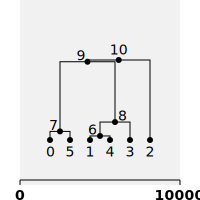

In [5]:
display(SVG(tree_sequence.draw_svg()))

The `tree_sequence` object is a so-called succinct (compact) data structure representation of trees along the sequence, based on the fact that neighbouring genomic regions have correlated genealogical histories. The interested reader can consult the tskit documentation (https://tskit.readthedocs.io/en/latest/data-model.html?highlight=succinct#definitions) for more information. As the name implies, it consists of a sequence of trees, where a tree represents a part of the sequence that has a given genealogy. Since we have no recombination events, there should only be one tree:

In [6]:
len(list(tree_sequence.trees()))

1

Recombination events are added via the `recombination_rate` parameter:

In [7]:
tree_sequence = msprime.simulate(sample_size=6, Ne=1000, length=1e4, random_seed=46, recombination_rate=2e-8)

Now, because of recombination, different parts of the sequence will have different histories, or genealogies. Consequently, we have several trees along the sequence:

In [8]:
len(list(tree_sequence.trees()))

4

where the lengths of the non-recombining segments and the genealogies of the segments can be obtained as follows:

In [9]:
for tree in tree_sequence.trees():
...     print("-" * 20)
...     print("tree {}: interval = {}".format(tree.index, tree.interval))
...     print(tree.draw(format="unicode"))

--------------------
tree 0: interval = Interval(left=0.0, right=3981.491488865924)
  13       
┏━━┻━━┓    
┃    10    
┃   ┏━┻━━┓ 
┃   ┃    9 
┃   ┃   ┏┻┓
┃   8   ┃ ┃
┃  ┏┻━┓ ┃ ┃
┃  6  ┃ ┃ ┃
┃ ┏┻┓ ┃ ┃ ┃
0 1 2 4 3 5

--------------------
tree 1: interval = Interval(left=3981.491488865924, right=7903.793365206522)
  12       
┏━━┻━━┓    
┃    10    
┃   ┏━┻━━┓ 
┃   ┃    9 
┃   ┃   ┏┻┓
┃   8   ┃ ┃
┃  ┏┻━┓ ┃ ┃
┃  6  ┃ ┃ ┃
┃ ┏┻┓ ┃ ┃ ┃
0 1 2 4 3 5

--------------------
tree 2: interval = Interval(left=7903.793365206522, right=9801.238693716294)
   12      
 ┏━━┻━━━┓  
 ┃     10  
 ┃    ┏━┻━┓
 ┃    8   ┃
 ┃   ┏┻━┓ ┃
 7   ┃  ┃ ┃
┏┻┓  ┃  ┃ ┃
┃ ┃  6  ┃ ┃
┃ ┃ ┏┻┓ ┃ ┃
0 3 1 2 4 5

--------------------
tree 3: interval = Interval(left=9801.238693716294, right=10000.0)
   11      
 ┏━━┻━━━┓  
 ┃     10  
 ┃    ┏━┻━┓
 ┃    8   ┃
 ┃   ┏┻━┓ ┃
 7   ┃  ┃ ┃
┏┻┓  ┃  ┃ ┃
┃ ┃  6  ┃ ┃
┃ ┃ ┏┻┓ ┃ ┃
0 3 1 2 4 5



Plotted as a svg, we see the tree sequence along the sequence:


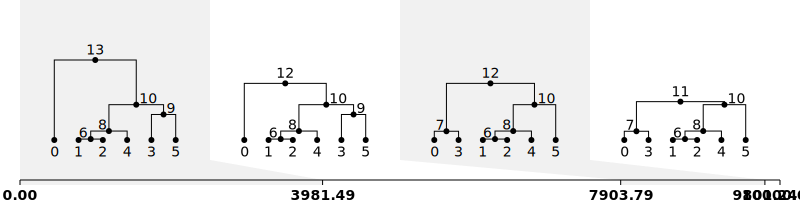

In [10]:
display(SVG(tree_sequence.draw_svg()))

If you study the sequence of trees, you see that they change along the sequence, reflecting the fact that they due to recombination have separate histories. Note also that neighbouring trees are correlated, that is, they have similar topologies. One can transform a tree to a neigbouring tree via simple subtree prune and regraft operations. This observation may seem to indicate that the trees are Markovian, i.e. the state of a tree only depends on its predecessor. That is not strictly true however as there are more long-range correlations. However, this assumption is often made in so-called Sequentially Markovian Coalescent models, on which for instance PSMC and MSMC are based.

This means that if we could infer genealogies along a sequence, we could also infer the recombination break points. However, in order to infer genealogies, we need sequence variation, or mutations. Mutations are added by applying the `mutation_rate` parameter:

In [11]:
tree_sequence = msprime.simulate(sample_size=6, Ne=1000, length=50e3, mutation_rate=1e-8, random_seed=30)
tree = tree_sequence.first()
for site in tree.sites():
    for mutation in site.mutations:
        print("Mutation @ position {:.2f} over node {}".format(site.position, mutation.node))

Mutation @ position 1556.54 over node 9
Mutation @ position 4485.17 over node 6
Mutation @ position 9788.56 over node 6
Mutation @ position 11759.03 over node 6
Mutation @ position 11949.32 over node 6
Mutation @ position 14321.77 over node 9
Mutation @ position 31454.99 over node 6
Mutation @ position 45125.69 over node 9
Mutation @ position 49709.68 over node 6


We can illustrate where the mutations occur by plotting the tree in svg format:

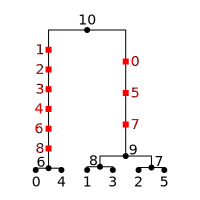

In [93]:
display(SVG(tree.draw_svg()))

The leaves correspond to sequences that we observe. Here, sequences 0 and 4 will share 6 mutations (1,2,3,4,6, and 8), whereas sequences 1,2,3, and 5 share three mutations (0, 5, and 7).

Now we combine mutation and recombination and plot the entire tree sequence, as a final visualization of the simulated data:

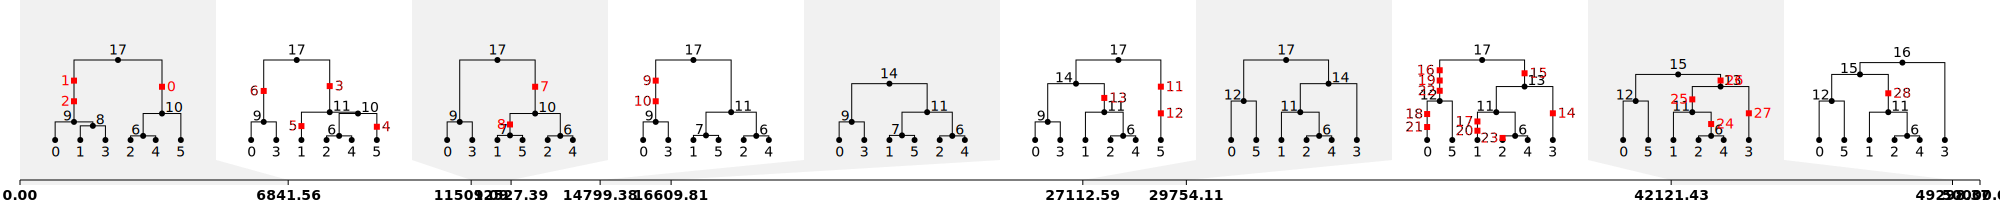

In [13]:
tree_sequence = msprime.simulate(sample_size=6, Ne=1000, length=50e3, mutation_rate=1e-7, random_seed=40, recombination_rate=2e-8)
display(SVG(tree_sequence.draw_svg()))

Modify the mutation rate and recombination rate a couple of times to make sure you understand how they affect the final output.

# Simulating data with flat recombination rate

Now that we have tested msprime, let's use it to simulate data. The data will need to be preprocessed prior to modelling, and we will look at the preprocessing steps by first looking at one simulated data set.

We start with the simplest possible example: a set of sequences generated by a process with a flat recombination rate. We simulate 10kb sequences, sample size $n=10$ from a population with effective population size $N_e=1000$. We choose small values for population size and sequence length to speed up simulations, but must then increase the mutation rate in order to obtain observable events. 

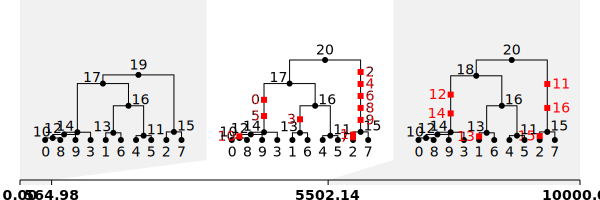

CPU times: user 42 ms, sys: 3.78 ms, total: 45.8 ms
Wall time: 143 ms


In [14]:
%%time
sample_size = 10
obs1 = msprime.simulate(sample_size=sample_size, Ne=1000, length=1e4, random_seed=42, mutation_rate=1e-7, recombination_rate=1e-8)
display(SVG(obs1.draw_svg()))

We print the number of sites and nucleotide diversity ($\pi$) for the observed data:

In [15]:
(obs1.get_num_sites(), obs1.diversity())

(17, array(0.00061333))

and make two plots of the data. First, for illustration purposes, we plot the entire sequence alignment. However, since the tree sequences only store segregating sites, we need to pad the genotypes with monomorphic sites. We use a helper function `utils.fill_pad` for this purpose; the `utils` module (living in the notebook directory) contains more utility functions that will be used later on. 

[953, 976, 991]


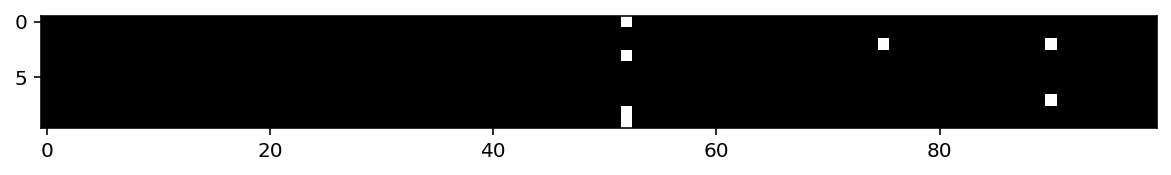

In [16]:
x = utils.fill_pad(obs1.genotype_matrix(), np.array([s.position for s in obs1.sites()]), 10000)
plt.figure(figsize = (10,20))
p = plt.imshow(x[900:1000, :].T, cmap='gray')
print([int(s.position) for s in obs1.sites()][0:3])

Here we plot positions 900-1000 (x-axis; tick labels do not refer to sequence position). The samples are on the y axis. Black pixels indicate monomorphic sites, white segregating sites that occupy sequence positions 953, 976, and 991.

Second, for comparison we plot the unpadded genotype matrix:

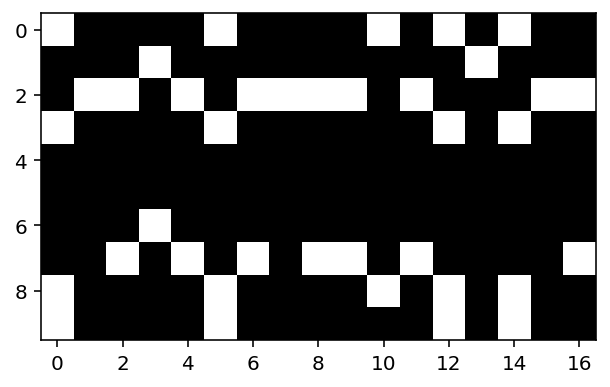

In [18]:
plt.figure(figsize = (10,3))
p = plt.imshow(obs1.genotype_matrix().T, cmap='gray')

Looking from left to right, we see that the three first columns correspond to the positions 953, 976, and 991.

The data we present to the model consists of the genotype matrices as monomorphic positions offer no additional information. Sequence *positions* do however - the farther apart two loci are, the greater the probability of a recombination event in between them - so in addition to the genotypes, we need to keep track of the positions. Hence, the input data will consist of:

1. genotype data
2. positional information
3. a known recombination rate that was use to simulate the data (our training "target")

## Data preprocessing

The data still needs to be preprocessed. The following steps are performed in ReLERNN; we will apply a select number (but should you be in a groove you are free to implement them all!):

1. the genotype matrix is padded with value -1.0 so that all examples are of equal size
2. likewise, the position vector is padded with 0
3. samples are shuffled and haplotypes sorted by similarity
4. the alignment is padded by a frame (after shuffling)
5. the recombination rates are z-score normalized

### Data padding

Input data needs to be of equal lengths. Once we simulate data, we will keep track of the maximum number of segregating sites observed. Assume for now this is 30; we use `utils.pad` to pad our genotype matrix:


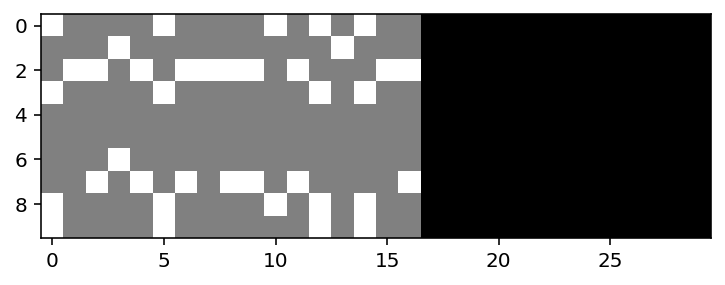

In [19]:
x, pos = utils.pad(obs1.genotype_matrix(), [s.position for s in obs1.sites()], maxsites=30)
p = plt.imshow(x.T, cmap='gray')

Since we added a new value (-1, black pixels), ancestral sites show up as gray.

As stated above, ReLERNN also adds a padding frame of width 5, which we show for illustration purposes (we will not use it later on):

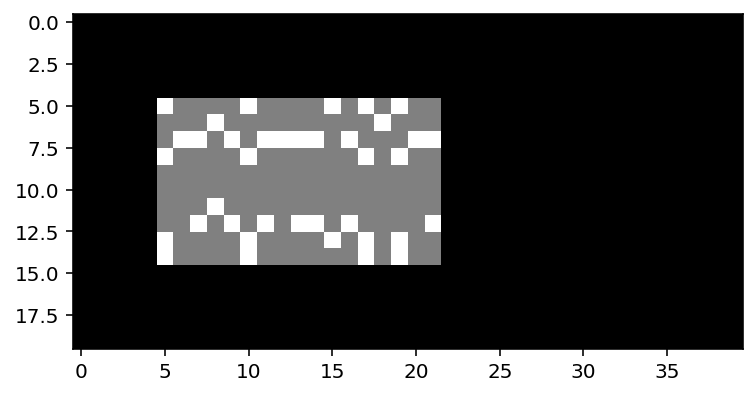

In [21]:
x, pos = utils.pad(obs1.genotype_matrix(), [s.position for s in obs1.sites()], maxsites=30, frameWidth=5)
p = plt.imshow(x.T, cmap='gray')

## Simulation of training, validation, and test data

The ReLERNN example pipeline simulates 100000 training, 1000 test and 2000 validation data sets. For practical reasons we here reduce these data set sizes somewhat. In general, we want to vary the mutation and recombination rates to generate data sets with different parametrizations. We therefore write a wrapper function to generate simulations and save the results. The function is also available in the `utils` module:

In [22]:
def simulate(nreps, outdir, seed=42, murange=(0, 2e-7), rhorange=(0, 2e-7), sample_size=10, Ne=1e4, length=1e4, **kwargs):
    """Simulate tree sequences with msprime and save genotype matrix and positions to outdir"""
    if not os.path.exists(outdir):
        os.makedirs(outdir)
    mu = [np.random.uniform(murange[0], murange[1]) for _ in range(nreps)]
    rho = [np.random.uniform(rhorange[0], rhorange[1]) for _ in range(nreps)]
    S = np.empty(nreps, dtype="int64")
    for i in range(nreps):
        ts = msprime.simulate(random_seed=seed, sample_size=sample_size, Ne=Ne, length=length,
                              mutation_rate=mu[i], recombination_rate=rho[i], **kwargs)
        np.save(os.path.join(outdir, f"{i}_haps.npy"), ts.genotype_matrix())
        np.save(os.path.join(outdir, f"{i}_pos.npy"), np.array([s.position for s in ts.sites()], dtype="float32"))
        S[i] = ts.get_num_sites()
    info = {'mu': mu, 'rho': rho, 'S': S, 'nreps': nreps, 'dataset': outdir,
            'sample_size': sample_size, 'Ne': Ne, 'length': length}
    with open(os.path.join(outdir, "info.p"), "wb") as fh:
        pickle.dump(info, fh)

The function generates random values for mutation rate $\mu$ and recombination rate $\rho$, and then iterates `nreps` times to call msprime with different parameter values, saving the results in the directory pointed to by `outdir`.

Now, let's simulate some data sets - 11100 in total. This will likely take less than two minutes!

In [23]:
%%time
# On my laptop (3.1GHz Dual-core intel i7) it takes approx 1s per 200 samples, total space ~ 125Mb
assumedMu = 1e-8
upperRhoThetaRatio = 1.0
murange = (0.66*assumedMu, 1.33*assumedMu) # Constrain mu values
rhorange = (0.0, assumedMu * upperRhoThetaRatio) # constrain upper value of rho
params = {'murange': murange, 'rhorange': rhorange, 'length': 1e5, 'sample_size': 10, 'Ne': 40000}
simulate(10000, "train", **params)
simulate(100, "test", **params)
simulate(1000, "vali", **params)

CPU times: user 1min 17s, sys: 3.15 s, total: 1min 21s
Wall time: 1min 34s


We read and extract relevant info from the pickled information files `info.p` for each data set and summarize stats for a sanity check. Since we have $n=10$ samples, effective population size $N_e=40000$ and simulate $L=10000$ bp sequences, we expect $E(S) = 4 * N_e * \mu * a * L$ number of segregating sites, where $a=\sum_{i=1}^{n-1}\frac{1}{i}$.

In [24]:
traininfo = pickle.load(open(os.path.join("train", "info.p"), "rb"))
valiinfo = pickle.load(open(os.path.join("vali", "info.p"), "rb"))
testinfo = pickle.load(open(os.path.join("test", "info.p"), "rb"))
data = pd.DataFrame({})
for k in ['S', 'rho', 'mu']:
    data[k] = np.concatenate((traininfo[k], valiinfo[k], testinfo[k]))
i = np.arange(1, traininfo["sample_size"])
a = sum(1/i)
data["Sexp"] = a * 4 * traininfo["Ne"] * data.mu * traininfo["length"]  # theta = E(pi) = S/a = 4*Ne*mu

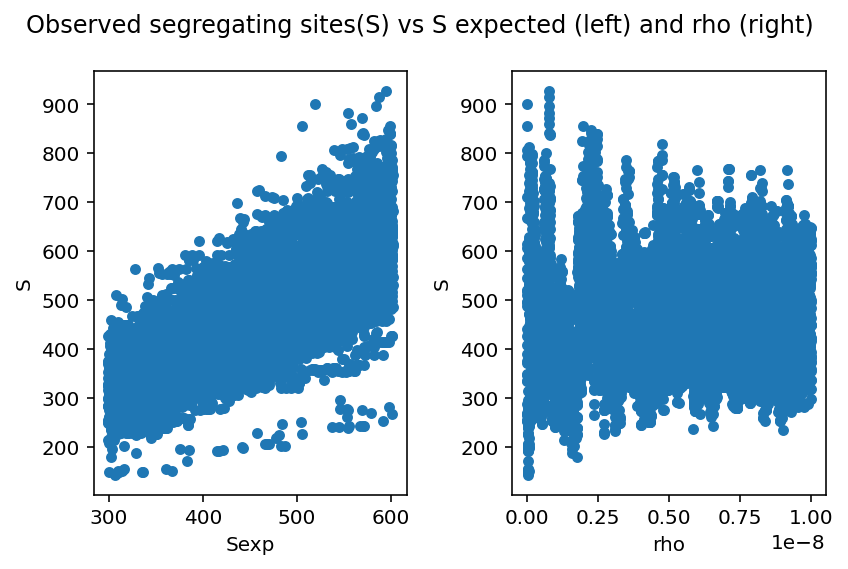

In [25]:
fig, axes = plt.subplots(nrows=1,ncols=2)
data.plot.scatter(x="Sexp", y="S", ax = axes[0], subplots=True, 
                  title="Observed segregating sites(S) vs S expected (left) and rho (right) ") 
data.plot.scatter(x="rho", y="S", ax = axes[1], subplots=True)
fig.tight_layout()
plt.show()

## Sequence generators for training

Even with this toy example, there may be memory issues when loading all training data. Therefore, it is better to generate data on the fly and provide it in batches during training. We use the `tf.keras.utils.Sequence` base class to achieve this purpose. See https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly for a concise treatment of this topic.

We here present the code in pieces. The subclass is available as `utils.sequenceBatchGenerator`.

First, we setup a generator object. The `on_epoch_end` is run at the end of an epoch, and here one typically shuffles the order of the data presented to the network. The functions `__len__` and `__getitem__` **must** be implemented. `normalizeRho` converts target recombination rates to Z-scores.

In [26]:
def __init__(self, datadir, maxlen, batchSize=16, frameWidth=0, seed=None):
    self.datadir = datadir
    self.info = pickle.load(open(os.path.join(datadir, "info.p"), "rb"))
    self.n_data = self.info["nreps"]
    self.maxlen = maxlen
    self.batchSize = batchSize
    self.frameWidth = frameWidth
    self.rhoZ = self.normalizeRho()
    self.on_epoch_end()

def on_epoch_end(self):
    """Shuffle indices to randomize order of training examples on epoch end"""
    self.indices = np.arange(self.n_data)
    np.random.shuffle(self.indices)
    
def normalizeRho(self):
    """Convert rho to Z-scores"""
    rhoZ = copy.deepcopy(self.info["rho"])
    rho_mean = np.mean(rhoZ, axis=0)
    rho_sd = np.std(rhoZ, axis=0)
    rhoZ -= rho_mean
    rhoZ = np.divide(rhoZ, rho_sd, out=np.zeros_like(rhoZ),
                     where=rho_sd != 0)
    return rhoZ

def __len__(self): # must be implemented
    """Get the number of batches per epoch as the number of data points divided by batch size"""
    return int(np.floor(self.n_data / self.batchSize))

def __getitem__(self, index): # must be implemented
    """Generate data indices for a given batch index (where index <= len(self))"""
    batchIndices = self.indices[index * self.batchSize: (index+1) * self.batchSize]
    X, y = self.__data_generation(batchIndices)
    return X, y

The actual data generation is done by the `__data_generation` function, which we present here:

In [28]:
def __data_generation(self, batchIndices):
    """Required core function to generate data batch"""
    haps = []
    pos = []
    # Read one dataset at a time
    for i in batchIndices:
        H = np.load(os.path.join(self.datadir, f"{i}_haps.npy"))
        P = np.load(os.path.join(self.datadir, f"{i}_pos.npy"))
        P = P / self.info["length"]
        # Add shuffling of individuals, reorganization of
        # haplotypes takes place here
        hpad, ppad = pad(H, P, self.maxlen, frameWidth=self.frameWidth)
        haps.append(hpad)
        pos.append(ppad)
    haps = np.array(haps, dtype="float32") # (batchSize, nSites, nsamples)
    pos = np.array(pos, dtype="float32") # (batchSize, nSites)
    rhoZ = [[t] for t in self.rhoZ[batchIndices]]
    return [haps, pos], np.array(rhoZ) # X, y

We load `batchSize` data sets, where the `batchIndices` have been selected in the `__getitem__` method. The data sets are padded before we return them. Note that here we could do additional preprocessing, such as shuffling individuals.

That's actually all that is needed! We can now define three sequence batch generators for the data sets:

In [29]:
frameWidth = 0
Smax = max(data["S"])
train_sequence = utils.sequenceBatchGenerator("train", Smax, frameWidth=frameWidth)
test_sequence = utils.sequenceBatchGenerator("test", Smax, frameWidth=frameWidth)
vali_sequence = utils.sequenceBatchGenerator("vali", Smax, frameWidth=frameWidth)

## Model definition

Now that we have gone through the painstaking endeavours that data mangling and preprocessing present, we are ready to start modelling. This will actually require less coding than until now. 

We begin by writing a wrapper function for our model, which is slightly modified from the version by Adrion et al, whose model looks like this:

<img src="relernn_network.png" width="300"></img>

In [31]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model

# Modelled on ReLERNN.networks.GRU_TUNED84
def GRU(x, y):
    haps, pos = x
    nsites = haps[0].shape[0]
    nsamples = haps[0].shape[1]
    npos = pos[0].shape[0]

    # Define input layer that takes a genotype matrix; recall that genotype matrix stores data as (nsites, nsamples)
    genotype_inputs = layers.Input(shape=(numSnps, sample_size))
    # analyze sequences in both directions, GRU more computationally efficient than LSTM
    model = layers.Bidirectional(layers.GRU(84, return_sequences=False))(genotype_inputs)
    # Add dense layer with 256 neurons in output space
    model = layers.Dense(256)(model)

    # Define input layer for positions
    position_inputs = layers.Input(shape=(npos,))
    m2 = layers.Dense(256)(position_inputs)

    # Concatenate genotype matrix and position input layers
    model = layers.concatenate([model, m2])
    # Add Dense and output layer that outputs a (normalized) recombination value
    model = layers.Dense(64)(model)
    output = layers.Dense(1)(model)

    model = Model(inputs=[genotype_inputs, position_inputs], outputs=[output])
    model.compile(optimizer="Adam", loss="mse")
    models.summary()
    return model

Briefly, genotype inputs are fed to a bidirectional Gated Recurrent Unit which are then fed to a dense layer. Positional inputs are fed to a dense layer, the two layers are concatenated and finally output as a scalar value reperesenting recombination rate. We access the function as `utils.GRU` and define a model:


In [33]:
# Need x and y to determine network topology details
x, y = train_sequence.__getitem__(0)
model = utils.GRU(x, y)

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 928, 10)]    0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 168)          48384       input_3[0][0]                    
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 928)]        0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 256)          43264       bidirectional_1[0][0]            
_______________________________________________________________________________________

## Model fitting


We now fit our model. Depending on time, you may have to adjust the parameters. On my laptop, with 10 `steps_per_epoch` it takes approximately 1 min per epoch. The authors state that they run 200+ epochs, which obviously is outside the scope of this exercise.

In [34]:
%%time
history = model.fit(train_sequence, steps_per_epoch=10, epochs=10, validation_data=vali_sequence)

Epoch 1/10
10/10 [==============================] - 48s 5s/step - loss: 3.6727 - val_loss: 1.7067
Epoch 2/10
10/10 [==============================] - 41s 4s/step - loss: 1.3787 - val_loss: 1.1103
Epoch 3/10
10/10 [==============================] - 43s 4s/step - loss: 1.0112 - val_loss: 1.0724
Epoch 4/10
10/10 [==============================] - 48s 5s/step - loss: 0.9309 - val_loss: 0.9586
Epoch 5/10
10/10 [==============================] - 49s 5s/step - loss: 1.0342 - val_loss: 0.9411
Epoch 6/10
10/10 [==============================] - 46s 5s/step - loss: 1.0061 - val_loss: 1.1078
Epoch 7/10
10/10 [==============================] - 44s 4s/step - loss: 0.9983 - val_loss: 1.0218
Epoch 8/10
10/10 [==============================] - 49s 5s/step - loss: 1.0141 - val_loss: 0.9059
Epoch 9/10
10/10 [==============================] - 46s 5s/step - loss: 0.8980 - val_loss: 0.9156
Epoch 10/10
10/10 [==============================] - 40s 4s/step - loss: 0.9281 - val_loss: 0.8574
CPU times: user 6mi

We plot 

Finally, we predict some values 

In [ ]:
x, y = test_sequence.__getitem__(0)
model.predict(x), y

# Additional exercises

(WIP): if you have time over, here are some additional things to look at. You can still use the model from the previous section, even though in reality the simulations should be adjusted to cater for the conditions below. Until now we have just classified one window at a time, but we are interested in recombination landscapes. Since these types of analyses are window-based, we here apply our model to longer test data which we split into windows as input to the network.

## Recombination hotspot


Simulate a test data set with a recombination hotspot and see if you can model it. ReLERNN has special functionality to identify hotspots and breakpoints. Here we just emulate a hotspot by using the https://msprime.readthedocs.io/en/stable/api.html#msprime.RecombinationMap class. Adjust the settings to look at different cases.

In [88]:
positions = [0, 4e5, 5e5, 1e6]
rates = [1e-10, 1e-7, 1e-10, 0]
recmap = msprime.RecombinationMap(positions, rates)

In [89]:
x = np.repeat(positions, 2)[1:-1]
y = np.repeat(rates, 2)[:-2]

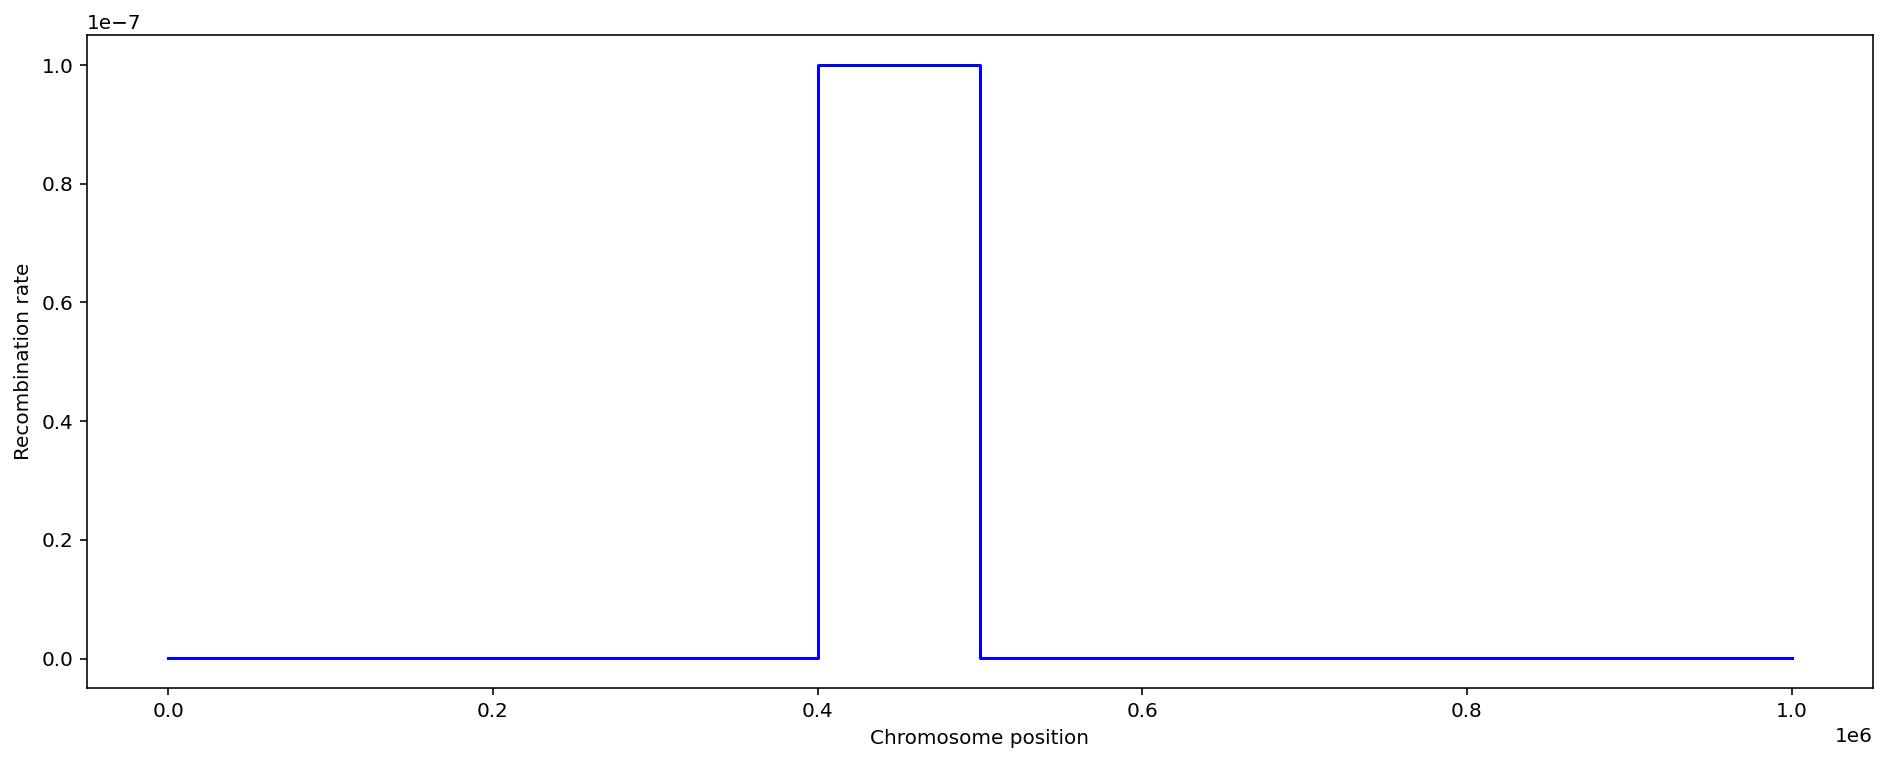

In [90]:
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(x, y, color="blue")
ax.set_ylabel("Recombination rate")
ax.set_xlabel("Chromosome position")
plt.show()

## A more realistic recombination map

Here we look at simulated data that are based on the recombination map in the file `genetic_map_chr22.txt`. We simulate according to https://msprime.readthedocs.io/en/stable/tutorial.html?highlight=recombination#recombination-maps

In [83]:
# wget ftp://ftp.ncbi.nlm.nih.gov/hapmap/recombination/latest/rates/genetic_map_chr22_b36.txt
# Add header to genetic_map_chr22.txt
# cat genetic_map_chr22_b36.txt | grep -v position | awk '{printf("%s\t%s\t%s\t%s\n", "chr22", $1, $2, $3)}' >> genetic_map_chr22.txt 

In [84]:
infile = "genetic_map_chr22.txt"
recomb_map = msprime.RecombinationMap.read_hapmap(infile)

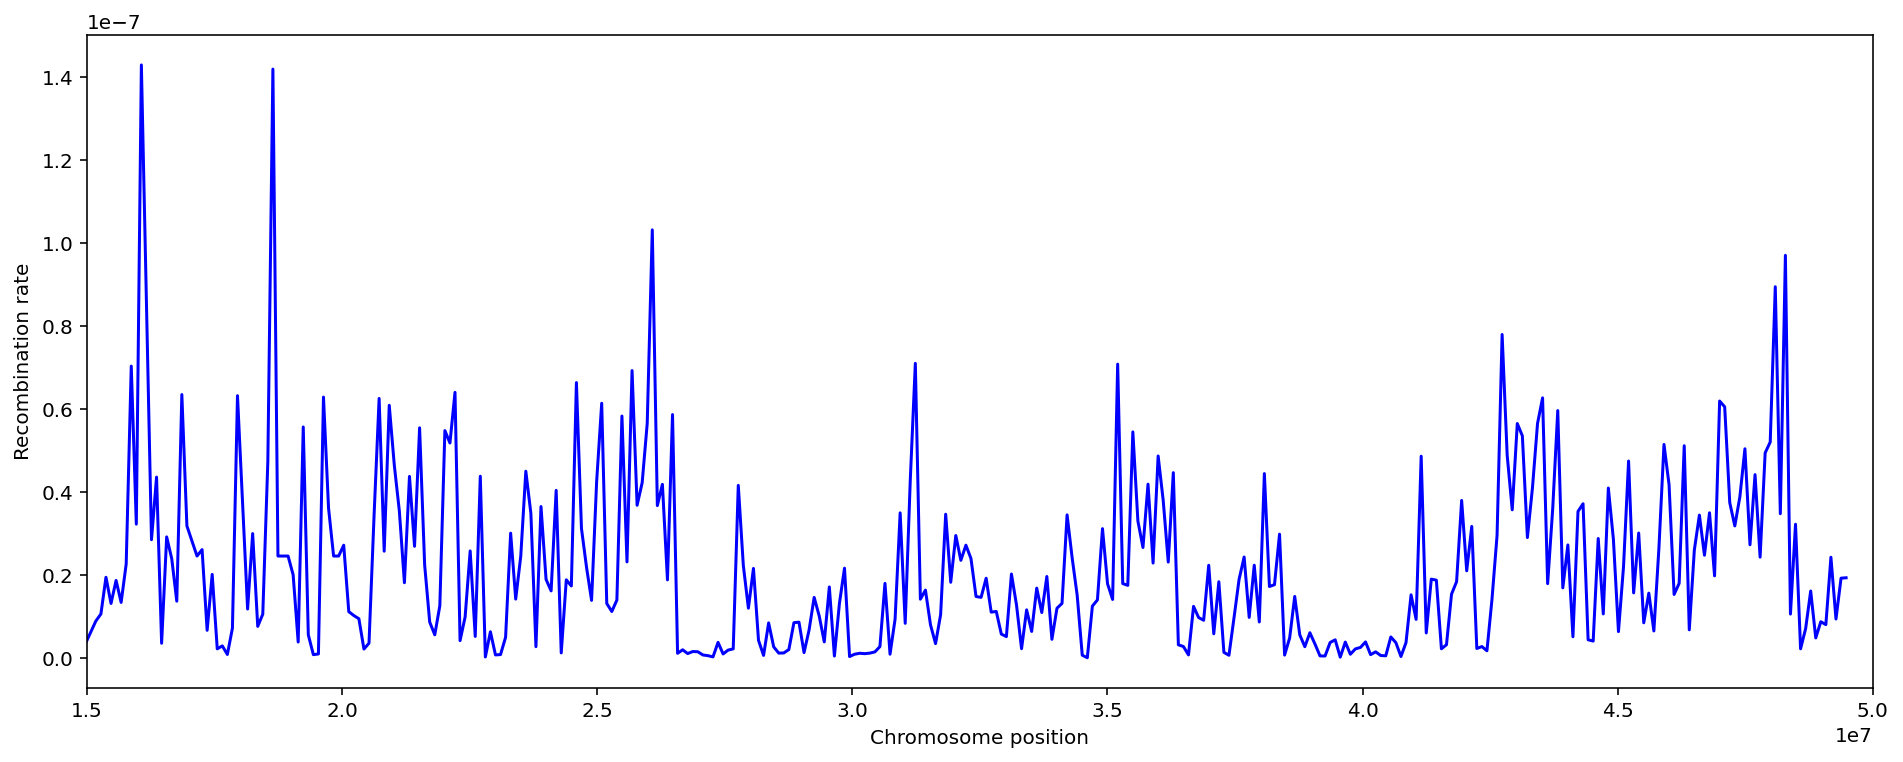

In [87]:
fig, ax = utils.plot_recombination_map(recomb_map)
ax.set_xlim(1.5e7, 5e7)
plt.show()

## Try out ReLERNN

Finally, if you feel like it, you can test ReLERNN itself. It comes with an example vcf and pipeline. Clone the repo, cd to `examples` and run the pipeline!


In [92]:
# !git clone git@github.com:kr-colab/ReLERNN.git
# !cd ReLERNN/examples
# !./example_pipeline.sh